# Setup

In [9]:
# %load_ext autoreload ##### autoreload conflicts with workflow
# %autoreload 2
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore, pearsonr, spearmanr
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import hdf5storage
from tqdm.notebook import tqdm
from neurodsp.spectral import compute_spectrum
from timescales.autoreg import compute_ar_spectrum
from timescales.fit import PSD, ACF
from ndspflow.workflows import WorkFlow
import timescale_development_hf as hf

In [10]:
# data directory
data_dir = '/Users/trevormcpherson/Desktop/PhD/Voytek/Organoids/organoidData/CTC/'
#'/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_data/CTC_data/'

# file type, constant, for each recording there is a directory that is the name of the recording, and then this file name within it
file_type = 'LFP_Sp.mat'

# all recording folders have this string in their name
recording_string = 'CTC'

# string to screen out drug manipulation recordings
drug_recording_string = 'Drugs'

# get recording directories
recording_directories = os.listdir(data_dir)

# only keep recording directories
recording_directories = [s for s in recording_directories if (recording_string in s) & (drug_recording_string not in s)]

# number of recordings
n_recordings = len(recording_directories)

# total number of wells
total_n_wells = 12

# no data in first 4 wells, if not specifying specific ones to analyze, skip these first 4
wells_to_skip = 4

# number of wells
n_wells = total_n_wells - wells_to_skip

# number of channels
n_channels = 64

# spike recording sample rate
spike_sample_rate = 12500 # samp per sec

# length of time bins using to separate spikes (seconds)
bin_length = 0.05

# binned data sample rate
bin_sample_rate = 1 / bin_length

# bin length in ms
bin_length_ms = int(bin_length * 1000)

# param for determining network spiking events, floor division of the maximum spikes found in a bin by this number
max_spike_floor_division = 2

# analysis window kernel (seconds, total of 3)
kernel_window_sec = [-0.5,2.5]

# length of kernel window
kernel_window_length = np.abs(kernel_window_sec[0]) + kernel_window_sec[1]

# convert to bins
kernel_window_idx = np.divide(kernel_window_sec,bin_length).astype(int)

num_bins_kernel = np.abs(kernel_window_idx[0]) + kernel_window_idx[1]
# get sequential times of bins in kernel

kernel_times = np.linspace(0,kernel_window_length,num_bins_kernel)

# day for organoid differentation as a time object
day_diff = datetime.strptime("081116",'%m%d%y')

# AR spectrum calculation order
ar_spec_order = [1,2,3,4,5]

# spike threshold (in step 3)
skp_thresh = 200 # remove electrodes with less than 200 spikes

# Analysis date
date_str = datetime.now().strftime('%Y-%m-%d_%H%M')
print(date_str)

2023-02-03_1012


In [12]:
# Update this with anaysis date printed from previous cell to save out a new version of the results
# or load a previously run version later in the script if visualizing
date_str = '2023-02-03_1012' # 2023-02-03_1012

In [14]:
work_flow_dir = '/Users/trevormcpherson/Desktop/PhD/Voytek/Organoids/work_flow_analysis/'
metadata_file = work_flow_dir + 'organoid_metadata.pkl'
kernel_bins_all_recordings_file = work_flow_dir + 'kernel_bins_all_recordings.pkl'
metadata_clean_file = work_flow_dir + 'organoid_metadata_clean.pkl'

fit_method = 'fooof' # fooof huber
workflow_file = work_flow_dir + 'workflow_run_' + fit_method + '_' + date_str + '.pkl'
workflow_file

'/Users/trevormcpherson/Desktop/PhD/Voytek/Organoids/work_flow_analysis/workflow_run_fooof_2023-02-03_1012.pkl'

# Processing

## Step 1: Collect meta data

In [15]:
# metadata column labels
metadata_column_labels = ['recording','day_postdiff','well','channel']
# initialise metadata dataframe
organoid_metadata = pd.DataFrame(columns=metadata_column_labels, dtype=object)

# loop through recordings
for this_recording_directory in recording_directories:
    # get date string
    date_string = this_recording_directory[4:10]
    
    # convert to date time object
    date_object = datetime.strptime(date_string,'%m%d%y')
    
    #convert data time object to days post differentiation
    dfdf = hf.get_dpdf(date_object, day_diff)

    # loop through wells
    for well_i in range(n_wells):
        # loop through channels
        for channel_i in range(n_channels):
            # build row for matadata dataframe
            df_row_list = [date_object, dfdf ,well_i,channel_i]
            df_row = pd.DataFrame([df_row_list], columns=metadata_column_labels)
            # add row to dataframe
            organoid_metadata = pd.concat([organoid_metadata, df_row])

In [16]:
with open(metadata_file, 'wb') as f:
    pickle.dump(organoid_metadata, f)

In [17]:
with open(metadata_file, 'rb') as f:
    organoid_metadata = pickle.load(f)

## Step 2: # Get network events kernels

In [9]:
# initialize list for storing network event kernels for each recording
network_event_kernels_all_recordings = []
# initialize list for storing kernel bins for each recording
kernel_bins_all_recordings = []
# loop through recordings
for this_recording_directory in recording_directories:
    print(this_recording_directory)
    # get mat file path
    mat_file_path = data_dir + this_recording_directory + '/' + file_type
    # load mat file
    data = hdf5storage.loadmat(mat_file_path)
    # get spikes
    spikes = data['spikes']
    # t_s - recording time in seconds
    time_sec = data['t_s']
    # get last time point in recording
    recording_end_time = np.floor(time_sec[-1])
    # number of time bins in this recording
    num_bins_recording = np.floor(recording_end_time / bin_length).astype('int')

    # loop through wells
    for well_i in range(wells_to_skip,total_n_wells):
        print(well_i)
        # get spikes for this well
        spikes_well = spikes[well_i]

        # initialzie to store all spike timestamps, and binned spikes for channels
        spike_times = np.array([])
        binned_spikes_all_channels = []
        # loop through channels
        for channel_i in range(n_channels):
            # get spikes for this channel
            spikes_channel = spikes_well[channel_i]
            # only bin if there are spikes
            if spikes_channel.size > 0:
                # get spike time stamps (seconds)
                spike_times_channel = spikes_channel / spike_sample_rate
                # store time stapms for this channel
                spike_times = np.concatenate((spike_times_channel.flatten(), spike_times))
                # binning function uses ms units, convert spike times to ms
                spike_times_channel_ms = spike_times_channel * 1000
                # binned spikes
                binned_spikes_channel = hf.bin_spikes(spike_times_channel_ms,bin_length_ms,fs=spike_sample_rate,n_recording_bins=num_bins_recording)
            else:
                binned_spikes_channel = np.array([])
            # store binned spikes for this channel
            binned_spikes_all_channels.append(binned_spikes_channel)

        # binning function uses ms units, convert spike times to ms
        spike_times_ms = spike_times * 1000
        # bin all spikes together
        binned_spikes_all = hf.bin_spikes(spike_times_ms,bin_length_ms,fs=spike_sample_rate,n_recording_bins=num_bins_recording)
        # get max number of spikes across all bins
        max_bin_spikes = max(binned_spikes_all)
        # set threshold for detecting large number of spikes
        network_event_thresh = max_bin_spikes // max_spike_floor_division
        # get indexes that are greater than threshold
        net_event_idxs = np.where(binned_spikes_all > network_event_thresh)[0]
        # number of network events
        num_net_events = len(net_event_idxs)

        # initialize list of total kernels we will be collecting - used to ensure there isnt overlap between kernels
        other_kernels = np.zeros((1,2))
        # initialize network events we will be storing
        network_kernels = np.zeros((1,2))
        # initialize and loop through network events
        for event in net_event_idxs:
            # define windows around each event onset
            kernel_start = event + kernel_window_idx[0]
            kernel_stop = event + kernel_window_idx[1]
            # assume we will store this kernel
            store_kernel = 1
            # only store if start and stop are both within the range of bins we have
            if kernel_start < 0 or kernel_stop > num_bins_recording:
                store_kernel = 0
            # only store if there is no overlap with previous kernels
            for previous_kernel in other_kernels:
                if previous_kernel[0] <= kernel_start <= previous_kernel[1] or previous_kernel[0] <= kernel_stop <= previous_kernel[1]:
                    store_kernel = 0
            # only store if mean firing rate is above 0
            net_spikes_this_kernel = binned_spikes_all[kernel_start:kernel_stop]
            mean_spiking_this_kernel = np.sum(net_spikes_this_kernel) / num_bins_kernel
            if mean_spiking_this_kernel <= 0:
                store_kernel = 0
            # store unless one of our conditions is not met
            if store_kernel:
                network_kernels = np.vstack((network_kernels, [kernel_start, kernel_stop])).astype(int)
                # also update total list of kernels
                other_kernels = np.vstack(
                    (other_kernels, [kernel_start, kernel_stop])).astype(int)
        # remove initializing zero row
        network_kernels = network_kernels[1:]
        # number of network kernels
        n_network_kernels = len(network_kernels)

        # loop through channels
        for channel_i in range(n_channels):
            # get binned spikes for this channel
            binned_spikes_channel = binned_spikes_all_channels[channel_i]
            # initialize list for kernels for this channel
            kernel_bins_all = []
            # loop though network kernels
            for kernel_i in range(n_network_kernels):
                # get kernel start and stop
                kernel_start = network_kernels[kernel_i][0]
                kernel_stop = network_kernels[kernel_i][1]
                # get bins for this kernel
                kernel_bins = binned_spikes_channel[kernel_start:kernel_stop]
                # store kernel for this channel
                kernel_bins_all.append(kernel_bins)
            # store kernel binned data
            kernel_bins_all_recordings.append(kernel_bins_all)
            # store network event kernels for this well
            network_event_kernels_all_recordings.append(network_kernels)

CTC_120616
4
5
6
7
8
9
10
11
CTC_100816
4
5
6
7
8
9
10
11
CTC_091316
4
5
6
7
8
9
10
11
CTC_122316
4
5
6
7
8
9
10
11
CTC_031617
4
5
6
7
8
9
10
11
CTC_012717
4
5
6
7
8
9
10
11
CTC_121616
4
5
6
7
8
9
10
11
CTC_080316
4
5
6
7
8
9
10
11
CTC_101816
4
5
6
7
8
9
10
11
CTC_111816
4
5
6
7
8
9
10
11
CTC_010617
4
5
6
7
8
9
10
11
CTC_100116
4
5
6
7
8
9
10
11
CTC_081016
4
5
6
7
8
9
10
11
CTC_112416
4
5
6
7
8
9
10
11
CTC_123016
4
5
6
7
8
9
10
11
CTC_022417
4
5
6
7
8
9
10
11
CTC_012017
4
5
6
7
8
9
10
11
CTC_031017
4
5
6
7
8
9
10
11
CTC_021017
4
5
6
7
8
9
10
11
CTC_102116
4
5
6
7
8
9
10
11
CTC_110416
4
5
6
7
8
9
10
11
CTC_101416
4
5
6
7
8
9
10
11
CTC_092016
4
5
6
7
8
9
10
11
CTC_082416
4
5
6
7
8
9
10
11
CTC_111016
4
5
6
7
8
9
10
11
CTC_073116
4
5
6
7
8
9
10
11
CTC_091616
4
5
6
7
8
9
10
11
CTC_011317
4
5
6
7
8
9
10
11
CTC_102816
4
5
6
7
8
9
10
11
CTC_100716
4
5
6
7
8
9
10
11
CTC_021717
4
5
6
7
8
9
10
11
CTC_120916
4
5
6
7
8
9
10
11
CTC_081616
4
5
6
7
8
9
10
11
CTC_092316
4
5
6
7
8
9
10
11
CTC_020717
4
5

In [ ]:
with open(kernel_bins_all_recordings_file, 'wb') as f:
    pickle.dump(kernel_bins_all_recordings, f)

In [18]:
with open(kernel_bins_all_recordings_file, 'rb') as f:
    kernel_bins_all_recordings = pickle.load(f)

## Step 3: Remove electrodes with no spikes

In [19]:
spiking_electrode_idxs  = [i for i in range(len(kernel_bins_all_recordings)) if np.array(kernel_bins_all_recordings[i]).sum() > skp_thresh]
kernel_bins_all_recordings_clean  = [kernel_bins_all_recordings[i] for i in spiking_electrode_idxs]
organoid_metadata_clean = organoid_metadata.iloc[spiking_electrode_idxs]
print(len(kernel_bins_all_recordings),len(kernel_bins_all_recordings_clean))

19968 14565


In [20]:
with open(metadata_clean_file, 'wb') as f:
    pickle.dump(organoid_metadata_clean, f)

In [21]:
with open(metadata_clean_file, 'rb') as f:
    organoid_metadata_clean = pickle.load(f)

## Step 4: Analysis with WorkFlow

In [22]:
# initialize work flow
wf = WorkFlow(y_array=kernel_bins_all_recordings_clean)

# set initial fork
wf.fork(0)
# compute kernel averaged power spectra - welch
wf.transform(hf.trial_average_spectrum_welch,bin_sample_rate,f_range=(.001, 200))
# spec param fit - welch
wf.fit(PSD(),method=fit_method)

# run for multiple AR spec orders
for this_ar_order in ar_spec_order:
    # reset fork
    wf.fork(0)
    # compute kernel averaged power spectra - ar
    wf.transform(hf.trial_average_spectrum_ar,bin_sample_rate,this_ar_order,f_range=(.001,200))
    # spec param fit - ar
    wf.fit(PSD(),method=fit_method)

In [23]:
# # Set up workflow analyses with r^2 weighting "sigma" input
# # Only works with "huber"/robustregression not spec param
# # Just run this block in addition to the previous to add the extra workflow analyses to the previous ones
# n_pts_welch = 10
# n_pts_ar = 2047
# welch_sigma = np.linspace(1, 10, n_pts_welch) / 10
# ar_sigma = np.linspace(1, 10, n_pts_ar) / 10
# welch_sigma_flip = np.flip(welch_sigma)
# ar_sigma_flip = np.flip(ar_sigma)

# # set initial fork - this time different weighting
# wf.fork(0)
# # compute kernel averaged power spectra - welch
# wf.transform(hf.trial_average_spectrum_welch,bin_sample_rate,f_range=(.001, 200))
# # spec param fit - welch
# wf.fit(PSD(),sigma=welch_sigma,method=fit_method)

# # run for multiple AR spec orders - this time different weighting
# for this_ar_order in ar_spec_order:
#     # reset fork
#     wf.fork(0)
#     # compute kernel averaged power spectra - ar
#     wf.transform(hf.trial_average_spectrum_ar,bin_sample_rate,this_ar_order,f_range=(.001,200))
#     # spec param fit - ar
#     wf.fit(PSD(),sigma=ar_sigma,method=fit_method)

# # set initial fork - this time different weighting FLIP
# wf.fork(0)
# # compute kernel averaged power spectra - welch
# wf.transform(hf.trial_average_spectrum_welch,bin_sample_rate,f_range=(.001, 200))
# # spec param fit - welch
# wf.fit(PSD(),sigma=welch_sigma_flip,method=fit_method)

# # run for multiple AR spec orders - this time different weighting FLIP
# for this_ar_order in ar_spec_order:
#     # reset fork
#     wf.fork(0)
#     # compute kernel averaged power spectra - ar
#     wf.transform(hf.trial_average_spectrum_ar,bin_sample_rate,this_ar_order,f_range=(.001,200))
#     # spec param fit - ar
#     wf.fit(PSD(),sigma=ar_sigma_flip,method=fit_method)

In [ ]:
%%time
# run work flow
wf.run(n_jobs=-1,progress=tqdm)

Running Workflow:   0%|          | 0/14565 [00:00<?, ?it/s]

/Users/trevormcpherson/opt/anaconda3/envs/vlab/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/trevormcpherson/opt/anaconda3/envs/vlab/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/trevormcpherson/opt/anaconda3/envs/vlab/lib/python3.10/site-packages/fooof/core/funcs.py:95: RuntimeWarning: overflow encountered in power
  f_e = xs**exp
/Users/trevormcpherson/opt/anaconda3/envs/vlab/lib/python3.10/site-packages/fooof/core/funcs.py:98: RuntimeWarning: invalid value encountered in divide
  ys = ys + np.log10((10**offset + (const * fk_e) + (const * f_e)) / (fk_e + f_e))
/Users/trevormcpherson/opt/anaconda3/envs/vlab/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= 

In [ ]:
with open(workflow_file, 'wb') as f:
    pickle.dump(wf, f)

In [ ]:
with open(workflow_file, 'rb') as f:
    wf = pickle.load(f)

# Results

In [ ]:
# load metadata
with open(metadata_clean_file, 'rb') as f:
    organoid_metadata_clean = pickle.load(f)
# load results
with open(workflow_file, 'rb') as f:
    wf = pickle.load(f)

In [ ]:
# For running with weighting and flipped weighting of the robust regression fits
knee_freq_ranges = [(0.5,7),(0,100),(0,100),(0,100),(0,100),(0,100)]
remove_outliers_zscore = 0
zscore_thresh = 4
spec_types = ['Welch','AR_1','AR_2','AR_3','AR_4','AR_5']

# # For running with weighting and flipped weighting of the robust regression fits
# knee_freq_ranges = [(0.5,7),(0,100),(0,100),(0,100),(0,100),(0,100),
#                    (0.5,7),(0,100),(0,100),(0,100),(0,100),(0,100),
#                    (0.5,7),(0,100),(0,100),(0,100),(0,100),(0,100)]
# remove_outliers_zscore = 0
# zscore_thresh = 4
# spec_types = ['Welch','AR_3','AR_6','AR_9','AR_12','AR_15',
#               'Welch_w','AR_3_w','AR_6_w','AR_9_w','AR_12_w','AR_15_w',
#               'Welch_wf','AR_3_wf','AR_6_wf','AR_9_wf','AR_12_wf','AR_15_wf']

In [ ]:
for spec_type_i,spec_type in enumerate(spec_types):
    knee_freq_range = knee_freq_ranges[spec_type_i]
    n_fits,n_spec_types = wf.results.shape

    taus = [wf.results[i][spec_type_i].tau for i in range(n_fits)]
    knee_freqs = [wf.results[i][spec_type_i].knee_freq for i in range(n_fits)]
    days = [organoid_metadata_clean['recording'].iloc[i].value for i in range(n_fits)]

    fig = plt.figure(figsize=(20,20))
    
    ax1 = plt.subplot(4,4,1)
    ax1.hist(knee_freqs,bins=100)
    ax1.set_title(spec_type + ' all knee freqs')
    
    ax2 = plt.subplot(4,4,2)
    ax2.hist(np.log10(knee_freqs),bins=100)
    ax2.set_title(spec_type + ' all knee freqs log')
    
    ax3 = plt.subplot(4,4,3)
    ax3.scatter(days,taus)
    ax3.set_title(spec_type + ' taus over development')
    
    ax4 = plt.subplot(4,4,4)
    ax4.scatter(days,np.log10(taus))
    ax4.set_title(spec_type + ' taus over development log')
                
    unique_recordings = np.unique(organoid_metadata_clean['recording'].values)
    unique_wells = np.unique(organoid_metadata_clean['well'].values)
    unique_channels = np.unique(organoid_metadata_clean['channel'].values)
    n_recordings = len(unique_recordings); n_wells = len(unique_wells); n_channels = len(unique_channels)
    compiled_data_taus = np.full((n_recordings,n_wells,n_channels),np.nan)
    compiled_data_knee_freqs = np.full((n_recordings,n_wells,n_channels),np.nan)
    compiled_data_days = np.full((n_recordings,n_wells,n_channels),np.nan)
    for rec_i,recording in enumerate(unique_recordings):
        for well_i,well in enumerate(unique_wells):
            for channel_i,channel in enumerate(unique_channels):
                this_idx_np = np.where((organoid_metadata_clean['recording'].values == recording) & (organoid_metadata_clean['well'].values == well) & (organoid_metadata_clean['channel'].values == channel))[0]
                if np.size(this_idx_np) > 0:
                    if len(this_idx_np) > 1:
                        breakme
                    this_idx = this_idx_np[0]
                    compiled_data_taus[rec_i,well_i,channel_i] = taus[this_idx]
                    compiled_data_knee_freqs[rec_i,well_i,channel_i] = knee_freqs[this_idx]
                    compiled_data_days[rec_i,well_i,channel_i] = days[this_idx]

    knee_freq_mask = (compiled_data_knee_freqs < knee_freq_range[0]) | (compiled_data_knee_freqs > knee_freq_range[1])
    compiled_data_taus_kfm = np.copy(compiled_data_taus); compiled_data_taus_kfm[knee_freq_mask] = np.nan
    compiled_data_knee_freqs_kfm = np.copy(compiled_data_knee_freqs); compiled_data_knee_freqs_kfm[knee_freq_mask] = np.nan
    compiled_data_days_kfm = np.copy(compiled_data_days); compiled_data_days_kfm[knee_freq_mask] = np.nan
                
    ax5 = plt.subplot(4,4,5)
    ax5.hist(compiled_data_knee_freqs_kfm.ravel(),bins=100)
    ax5.set_title(spec_type + ' masked knee freqs')
    
    ax6 = plt.subplot(4,4,6)
    ax6.hist(np.log10(compiled_data_knee_freqs_kfm.ravel()),bins=100)
    ax6.set_title(spec_type + ' masked knee freqs log')
    
    ax7 = plt.subplot(4,4,7)
    ax7.scatter(compiled_data_days_kfm,compiled_data_taus_kfm)
    ax7.set_title(spec_type + ' kfm taus over development')
    
    ax8 = plt.subplot(4,4,8)
    ax8.scatter(compiled_data_days_kfm,np.log10(compiled_data_taus_kfm))
    ax8.set_title(spec_type + ' kfm taus over development log')           
                
    compiled_data_taus_log = np.log10(compiled_data_taus)
    compiled_data_taus_kfm_log = np.log10(compiled_data_taus_kfm)

    compiled_data_taus_chan_mean = np.nanmean(compiled_data_taus,axis=2)
    compiled_data_taus_kfm_chan_mean = np.nanmean(compiled_data_taus_kfm,axis=2)
    compiled_data_taus_chan_mean_log = np.nanmean(compiled_data_taus_log,axis=2)
    compiled_data_taus_kfm_chan_mean_log = np.nanmean(compiled_data_taus_kfm_log,axis=2)

    if remove_outliers_zscore:
        compiled_data_taus_chan_mean[np.abs(zscore(compiled_data_taus_chan_mean,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan
        compiled_data_taus_kfm_chan_mean[np.abs(zscore(compiled_data_taus_kfm_chan_mean,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan
        compiled_data_taus_chan_mean_log[np.abs(zscore(compiled_data_taus_chan_mean_log,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan
        compiled_data_taus_kfm_chan_mean_log[np.abs(zscore(compiled_data_taus_kfm_chan_mean_log,axis=1,nan_policy='omit')) >= zscore_thresh] = np.nan

    ax9 = plt.subplot(4,4,9)
    ax9.plot(unique_recordings,compiled_data_taus_chan_mean)
    ax9.set_title(spec_type + ' chan avg taus over development')
    
    ax10 = plt.subplot(4,4,10)
    ax10.plot(unique_recordings,compiled_data_taus_chan_mean_log)
    ax10.set_title(spec_type + ' chan avg taus over development log')
    
    ax11 = plt.subplot(4,4,11)
    ax11.plot(unique_recordings,compiled_data_taus_kfm_chan_mean)
    ax11.set_title(spec_type + ' kfm taus over development')
    
    ax12 = plt.subplot(4,4,12)
    ax12.plot(unique_recordings,compiled_data_taus_kfm_chan_mean_log)
    ax12.set_title(spec_type + ' kfm taus over development log')
    
    compiled_data_taus_well_mean = np.mean(compiled_data_taus_chan_mean,axis=1)
    compiled_data_taus_well_std = np.std(compiled_data_taus_chan_mean,axis=1)
    taus_upper_bound = compiled_data_taus_well_mean + compiled_data_taus_well_std
    taus_lower_bound = compiled_data_taus_well_mean - compiled_data_taus_well_std

    compiled_data_taus_well_mean_log = np.mean(compiled_data_taus_chan_mean_log,axis=1)
    compiled_data_taus_well_std_log = np.std(compiled_data_taus_chan_mean_log,axis=1)
    taus_upper_bound_log = compiled_data_taus_well_mean_log + compiled_data_taus_well_std_log
    taus_lower_bound_log = compiled_data_taus_well_mean_log - compiled_data_taus_well_std_log

    compiled_data_taus_kfm_well_mean = np.mean(compiled_data_taus_kfm_chan_mean,axis=1)
    compiled_data_taus_kfm_well_std = np.std(compiled_data_taus_kfm_chan_mean,axis=1)
    taus_upper_bound_kfm = compiled_data_taus_kfm_well_mean + compiled_data_taus_kfm_well_std
    taus_lower_bound_kfm = compiled_data_taus_kfm_well_mean - compiled_data_taus_kfm_well_std

    compiled_data_taus_kfm_well_mean_log = np.mean(compiled_data_taus_kfm_chan_mean_log,axis=1)
    compiled_data_taus_kfm_well_std_log = np.std(compiled_data_taus_kfm_chan_mean_log,axis=1)
    taus_upper_bound_kfm_log = compiled_data_taus_kfm_well_mean_log + compiled_data_taus_kfm_well_std_log
    taus_lower_bound_kfm_log = compiled_data_taus_kfm_well_mean_log - compiled_data_taus_kfm_well_std_log

    compiled_data_days_kfm_chan_mean = np.nanmean(compiled_data_days_kfm,axis=2)
    compiled_data_days_kfm_well_mean = np.nanmean(compiled_data_days_kfm_chan_mean,axis=1)

    ax13 = plt.subplot(4,4,13)
    ax13.plot(compiled_data_days_kfm_well_mean,compiled_data_taus_well_mean,c='b',linewidth=2)
    ax13.fill_between(compiled_data_days_kfm_well_mean,taus_lower_bound,taus_upper_bound,color='b',alpha=0.2)
    ax13.set_title(spec_type + ' chan avg taus over development')
    
    ax14 = plt.subplot(4,4,14)
    ax14.plot(compiled_data_days_kfm_well_mean,compiled_data_taus_well_mean_log,c='b',linewidth=2)
    ax14.fill_between(compiled_data_days_kfm_well_mean,taus_lower_bound_log,taus_upper_bound_log,color='b',alpha=0.2)
    ax14.set_title(spec_type + ' chan avg taus over development log')
    
    ax15 = plt.subplot(4,4,15)
    ax15.plot(compiled_data_days_kfm_well_mean,compiled_data_taus_kfm_well_mean,c='b',linewidth=2)
    ax15.fill_between(compiled_data_days_kfm_well_mean,taus_lower_bound_kfm,taus_upper_bound_kfm,color='b',alpha=0.2)
    ax15.set_title(spec_type + ' kfm taus over development')
    
    ax16 = plt.subplot(4,4,16)
    ax16.plot(compiled_data_days_kfm_well_mean,compiled_data_taus_kfm_well_mean_log,c='b',linewidth=2)
    ax16.fill_between(compiled_data_days_kfm_well_mean,taus_lower_bound_kfm_log,taus_upper_bound_kfm_log,color='b',alpha=0.2)
    ax16.set_title(spec_type + ' kfm taus over development log')
    
    plt.suptitle(fit_method)
    plt.show() 
    
    pr_all_chan = pearsonr(
        compiled_data_days_kfm[~np.isnan(compiled_data_taus_kfm)],
        compiled_data_taus_kfm[~np.isnan(compiled_data_taus_kfm)])
    pr_all_chan_log = pearsonr(
        compiled_data_days_kfm[~np.isnan(compiled_data_taus_kfm_log)],
        compiled_data_taus_kfm_log[~np.isnan(compiled_data_taus_kfm_log)])
    pr_well_mean = pearsonr(
        compiled_data_days_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean)],
        compiled_data_taus_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean)])
    pr_well_mean_log = pearsonr(
        compiled_data_days_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean_log)],
        compiled_data_taus_kfm_well_mean_log[~np.isnan(compiled_data_taus_kfm_well_mean_log)])
    sr_all_chan = spearmanr(
        compiled_data_days_kfm[~np.isnan(compiled_data_taus_kfm)],
        compiled_data_taus_kfm[~np.isnan(compiled_data_taus_kfm)])
    sr_all_chan_log = spearmanr(
        compiled_data_days_kfm[~np.isnan(compiled_data_taus_kfm_log)],
        compiled_data_taus_kfm_log[~np.isnan(compiled_data_taus_kfm_log)])
    sr_well_mean = spearmanr(
        compiled_data_days_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean)],
        compiled_data_taus_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean)])
    sr_well_mean_log = spearmanr(
        compiled_data_days_kfm_well_mean[~np.isnan(compiled_data_taus_kfm_well_mean_log)],
        compiled_data_taus_kfm_well_mean_log[~np.isnan(compiled_data_taus_kfm_well_mean_log)])
    
    print(spec_type + ' PEARSON all chan:        r=' + str(round(pr_all_chan[0],3)) + ', p=' + str(round(pr_all_chan[1],3)))
    print(spec_type + ' PEARSON all chan log:    r=' + str(round(pr_all_chan_log[0],3)) + ', p=' + str(round(pr_all_chan_log[1],3)))
    print(spec_type + ' PEARSON well mean:       r=' + str(round(pr_well_mean[0],3)) + ', p=' + str(round(pr_well_mean[1],3)))
    print(spec_type + ' PEARSON well mean log:   r=' + str(round(pr_well_mean_log[0],3)) + ', p=' + str(round(pr_well_mean_log[1],3)))
    print(spec_type + ' SPEARMAN all chan:       r=' + str(round(sr_all_chan[0],3)) + ', p=' + str(round(sr_all_chan[1],3)))
    print(spec_type + ' SPEARMAN all chan log:   r=' + str(round(sr_all_chan_log[0],3)) + ', p=' + str(round(sr_all_chan_log[1],3)))
    print(spec_type + ' SPEARMAN well mean:      r=' + str(round(sr_well_mean[0],3)) + ', p=' + str(round(sr_well_mean[1],3)))
    print(spec_type + ' SPEARMAN well mean log:  r=' + str(round(sr_well_mean_log[0],3)) + ', p=' + str(round(sr_well_mean_log[1],3)))

# etc

In [107]:
spec_types = ['Welch','AR_1','AR_2','AR_3','AR_4','AR_5']
# spec_types = ['Welch','AR_3','AR_6','AR_9','AR_12','AR_15',
#               'Welch_w','AR_3_w','AR_6_w','AR_9_w','AR_12_w','AR_15_w',
#               'Welch_wf','AR_3_wf','AR_6_wf','AR_9_wf','AR_12_wf','AR_15_wf']

In [108]:
spec_type_i = 4
taus = [wf.results[i][spec_type_i].tau for i in range(n_fits)]
knee_freqs = [wf.results[i][spec_type_i].knee_freq for i in range(n_fits)]
days = [organoid_metadata_clean['recording'].iloc[i].value for i in range(n_fits)]
spec_types[spec_type_i]

'AR_6_w'

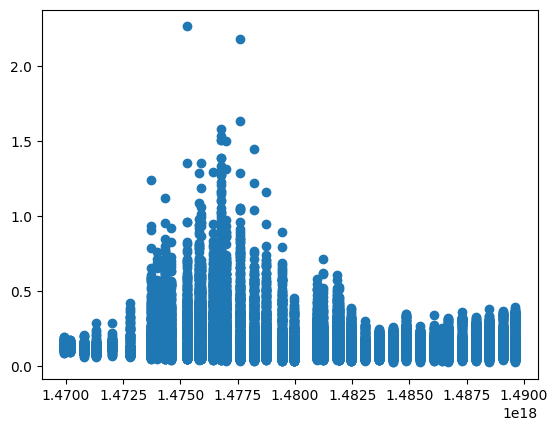

In [109]:
plt.scatter(days,taus)

In [111]:
tau_thresh = 2
big_tau_i = np.where(np.array(taus) > tau_thresh)[0]
big_tau_i

array([ 4265, 10351])

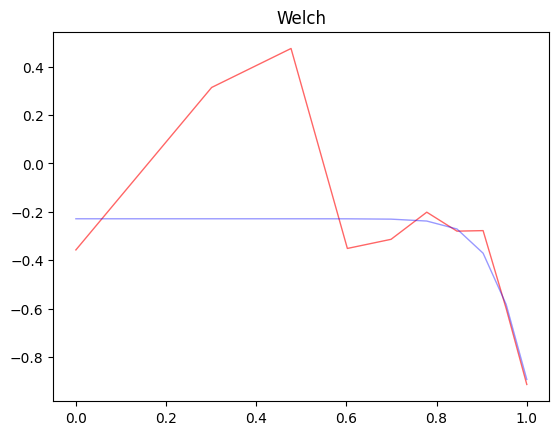

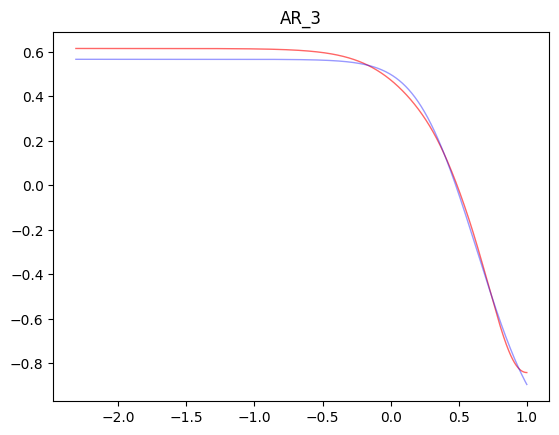

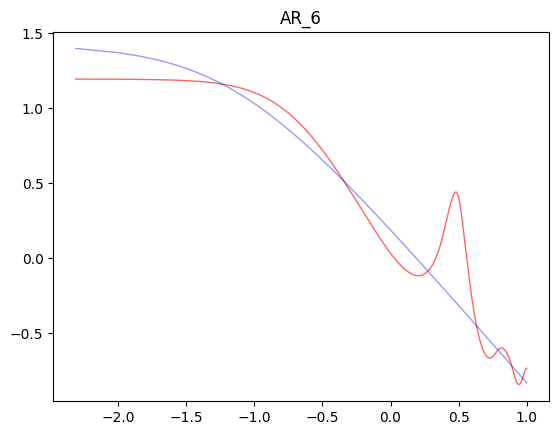

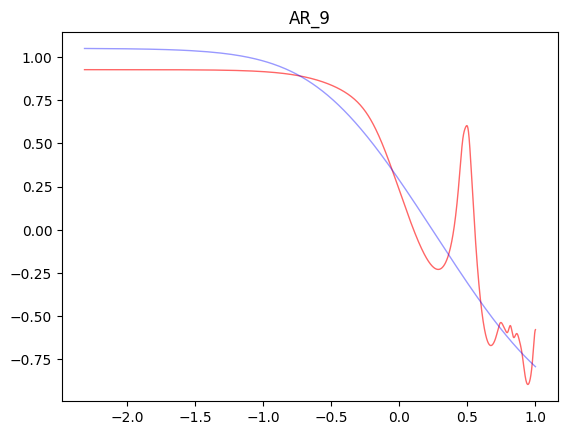

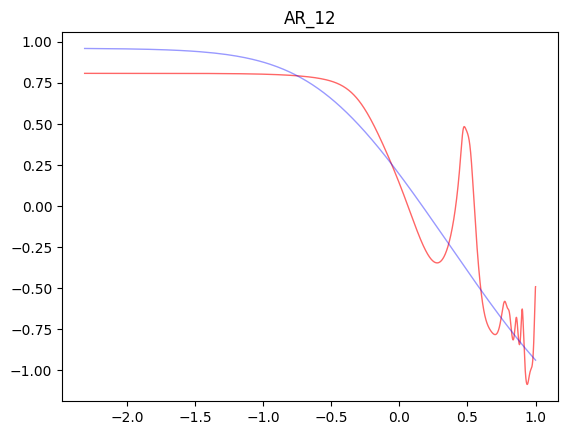

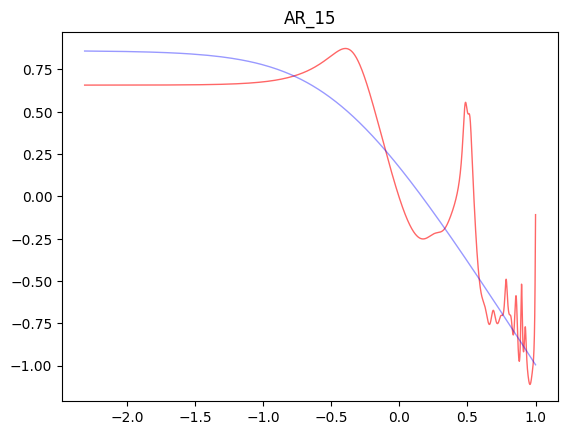

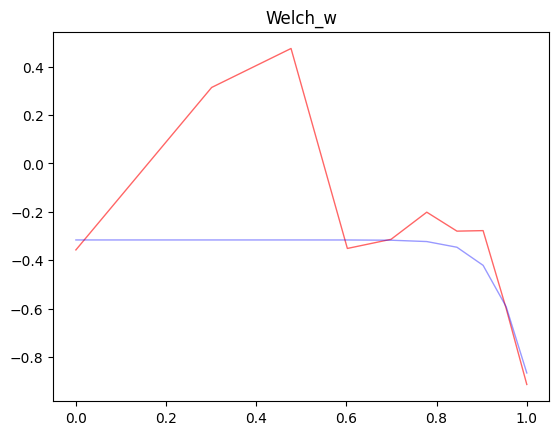

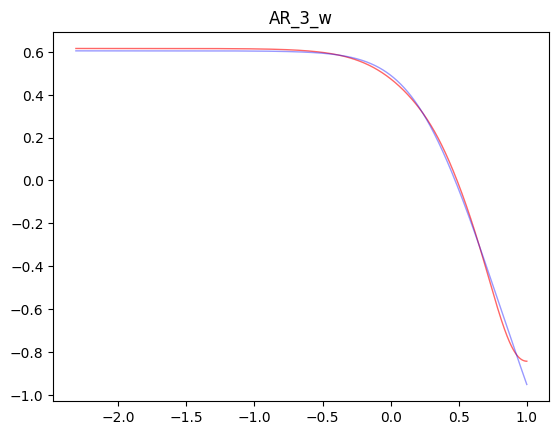

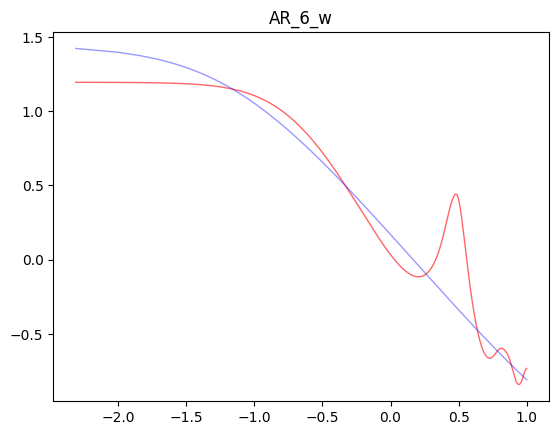

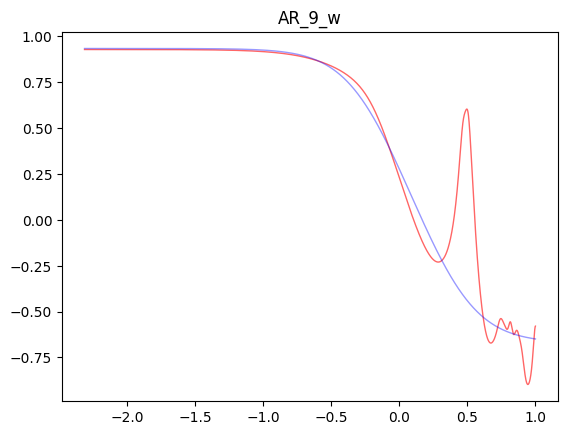

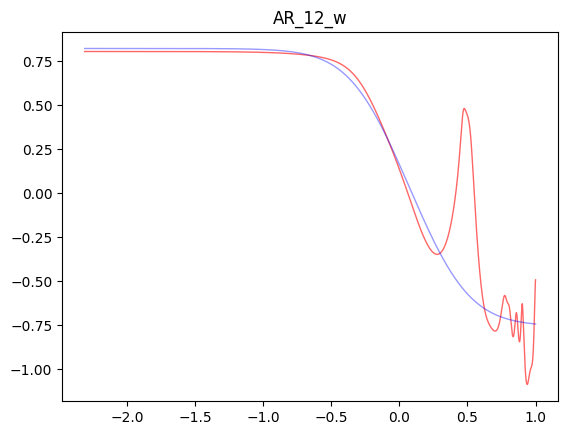

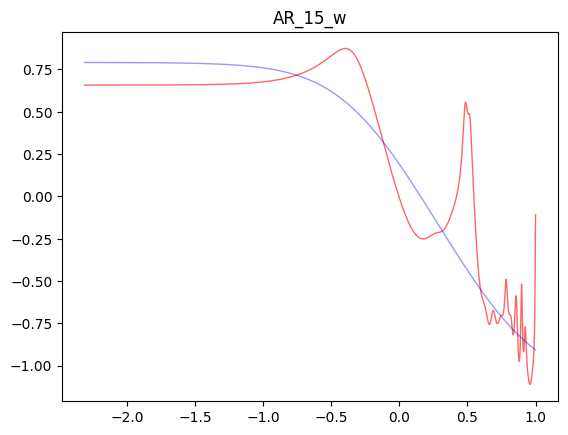

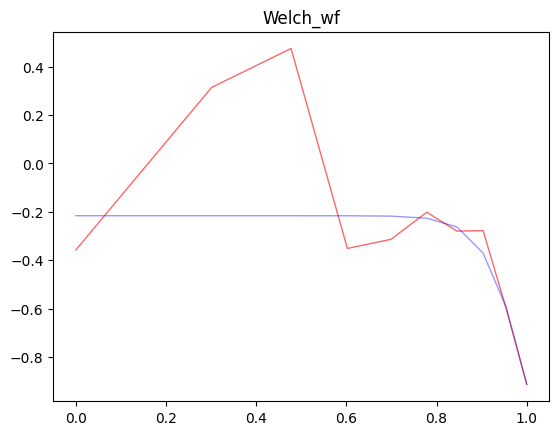

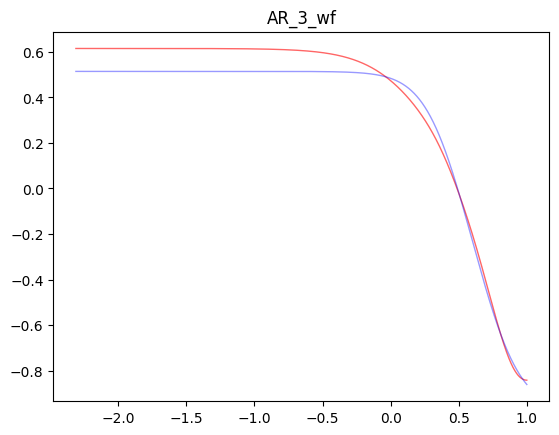

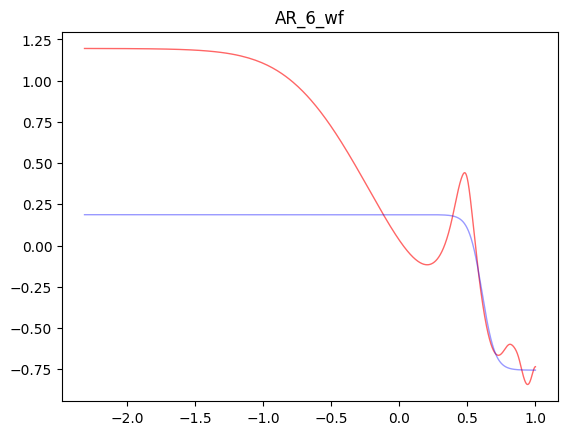

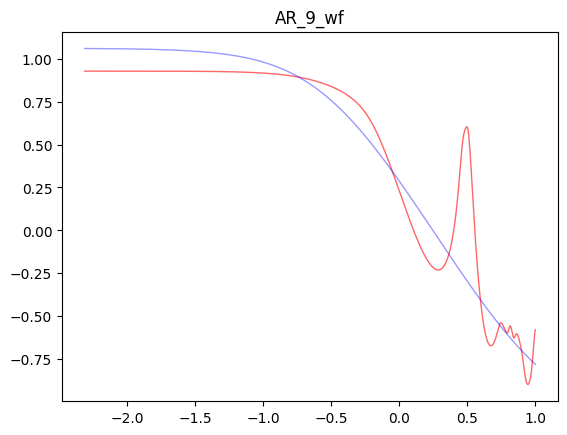

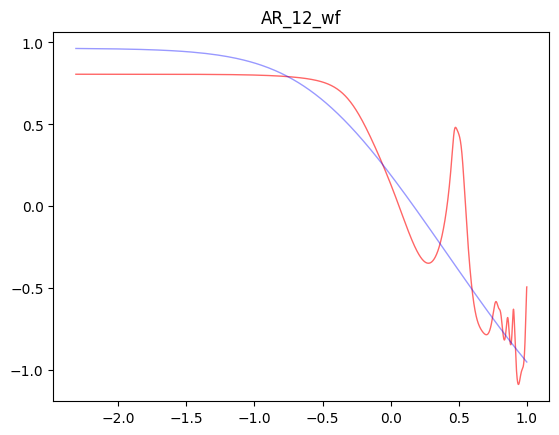

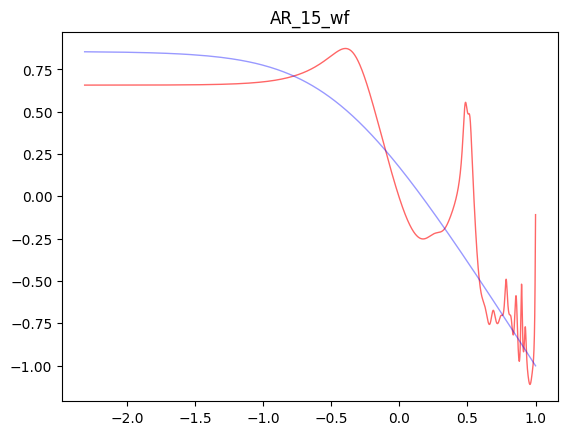

In [115]:
spec_is = [4265]#big_tau_i#[1,10,100,1000,10000]

for spec_type_i in range(len(spec_types)):
    plt.figure()
    for spec_i in spec_is:
        this_spec_freqs = wf.results[spec_i][spec_type_i].freqs
        this_spec_powers = wf.results[spec_i][spec_type_i].powers
        this_spec_powers_fit = wf.results[spec_i][spec_type_i].powers_fit

        plt.plot(np.log10(this_spec_freqs),np.log10(this_spec_powers),c='r',alpha=.6,linewidth=1)
        plt.plot(np.log10(this_spec_freqs),np.log10(this_spec_powers_fit),c='b',alpha=.4,linewidth=1)
        plt.title(spec_types[spec_type_i])
    plt.show()

In [63]:
# spec_is = big_tau_i#[1,10,100,1000,10000]

# for spec_i in spec_is:
#     plt.figure()
#     for spec_type_i in range(len(spec_types)):
#         this_spec_freqs = wf.results[spec_i][spec_type_i].freqs
#         this_spec_powers = wf.results[spec_i][spec_type_i].powers
#         this_spec_powers_fit = wf.results[spec_i][spec_type_i].powers_fit
    
#         plt.plot(np.log10(this_spec_freqs),np.log10(this_spec_powers),c='r',alpha=.6,linewidth=1)
#         plt.plot(np.log10(this_spec_freqs),np.log10(this_spec_powers_fit),c='b',alpha=.4,linewidth=1)
#     plt.show()